In [9]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Point
import rioxarray 
import os
import matplotlib as mpl
import seaborn as sns
import warnings


In [10]:
crops = ['Corn', 'Soybean', "Wheat", "Rice"]
phases = [1,2]

In [11]:
# Read in the data
gdf_dict = {}
for crop in crops:
    for phase in phases:
        rds = rioxarray.open_rasterio(
            "../" + os.sep + "processed" + os.sep + "output" + os.sep + crop + "_phase_" + str(phase) + "_rc_mean.asc"
        )
        rds = rds.squeeze().drop("spatial_ref").drop("band")
        rds.name = "data"
        df = rds.to_dataframe().reset_index().replace(-9, np.nan).dropna()
        #df = df.head(500)
        # Convert to geodataframe
        gdf_dict[crop+str(phase)] = df
        

In [12]:
def dataframe_to_geopandas(df):
    # Convert the x and y columns to longitude and latitude, respectively
    geometry = [Point(x, y) for x, y in zip(df['x'], df['y'])]
    
    # Create a GeoDataFrame from the geometry and data columns
    gdf = gpd.GeoDataFrame(df['data'], geometry=geometry)
    
    return gdf


In [13]:
# Convert the dataframes to geodataframes
gdf_dict_gpd = {}
for i in gdf_dict.keys():
    print(i)
    gdf_dict_gpd[i] = dataframe_to_geopandas(gdf_dict[i])

Corn1
Corn2
Soybean1
Soybean2
Wheat1
Wheat2
Rice1
Rice2


In [14]:
regions = gpd.read_file("../" + os.sep + "spatial_data" + os. sep + "regions" + os.sep + "ne_10m_admin_0_countries_lakes.shp")
regions = regions[(regions['CONTINENT'] != 'Antarctica') & (regions['CONTINENT'] != 'Seven seas (open ocean)')]
regions = regions[["CONTINENT", "geometry"]]
# Dissolve the geometries by region
regions = regions.dissolve(by="CONTINENT")
regions = regions.reset_index()
regions.to_crs("EPSG:4326", inplace=True)

In [15]:
region_yield_reduction_data = {"region":[], "crop":[], "phase":[], "yield_reduction":[]}
crop_phases = [(crop, phase) for crop in crops for phase in phases]
# Suppress the FutureWarning
warnings.simplefilter(action='ignore', category=FutureWarning)

for region in regions["CONTINENT"]:
    print(region)
    region_subset = regions[regions['CONTINENT'] == region]
    for crop, phase in crop_phases:
        print(crop, phase)
        region_yield_reduction_data["region"].append(region)
        region_yield_reduction_data["crop"].append(crop)
        region_yield_reduction_data["phase"].append(phase)
        yield_reduction = gdf_dict_gpd[crop + str(phase)].copy()
        yield_reduction.crs = "EPSG:4326"

        merged_gdf = gpd.sjoin(yield_reduction, region_subset, how="inner", op="intersects")
        # Calculate average values by continent
        merged_gdf["data"] = merged_gdf["data"] * 100
        reduction = merged_gdf["data"].mean()
        region_yield_reduction_data["yield_reduction"].append(reduction)

region_yield_reduction = pd.DataFrame(region_yield_reduction_data)


Africa
Corn 1
Corn 2
Soybean 1
Soybean 2
Wheat 1
Wheat 2
Rice 1
Rice 2
Asia
Corn 1
Corn 2
Soybean 1
Soybean 2
Wheat 1
Wheat 2
Rice 1
Rice 2
Europe
Corn 1
Corn 2
Soybean 1
Soybean 2
Wheat 1
Wheat 2
Rice 1
Rice 2
North America
Corn 1
Corn 2
Soybean 1
Soybean 2
Wheat 1
Wheat 2
Rice 1
Rice 2
Oceania
Corn 1
Corn 2
Soybean 1
Soybean 2
Wheat 1
Wheat 2
Rice 1
Rice 2
South America
Corn 1
Corn 2
Soybean 1
Soybean 2
Wheat 1
Wheat 2
Rice 1
Rice 2


In [16]:
# change phase to string
region_yield_reduction["phase"] = region_yield_reduction["phase"].astype(str)
region_yield_reduction.columns = ["Continent", "Crop", "Phase", "Yield Reduction (%)"]


In [17]:
region_yield_reduction.groupby("Phase").mean()

,Yield Reduction (%)
Phase,
1,-18.088866
2,-29.050429


In [18]:
region_yield_reduction.groupby(["Crop"]).mean()

,Yield Reduction (%)
Crop,
Corn,-23.357708
Rice,-27.526241
Soybean,-15.110612
Wheat,-26.874189


In [19]:
region_yield_reduction.groupby(["Crop", "Phase"]).mean()

Yield Reduction (%)
Crop    Phase                     
Corn    1               -16.807473
        2               -29.907943
Rice    1               -24.697628
        2               -30.354854
Soybean 1                -8.849280
        2               -21.371943
Wheat   1               -20.461151
        2               -33.287227

In [20]:
region_yield_reduction.groupby(["Continent"]).mean()

,Yield Reduction (%)
Continent,
Africa,-11.440133
Asia,-20.490279
Europe,-23.499914
North America,-28.824730
Oceania,-34.900311
South America,-25.095183


In [21]:
region_yield_reduction.groupby(["Continent", "Phase"]).mean()

Yield Reduction (%)
Continent     Phase                     
Africa        1                -9.895933
              2               -12.984332
Asia          1               -18.598485
              2               -22.382073
Europe        1               -16.493257
              2               -30.506571
North America 1               -20.674773
              2               -36.974688
Oceania       1               -27.518324
              2               -42.282298
South America 1               -17.709787
              2               -32.480579

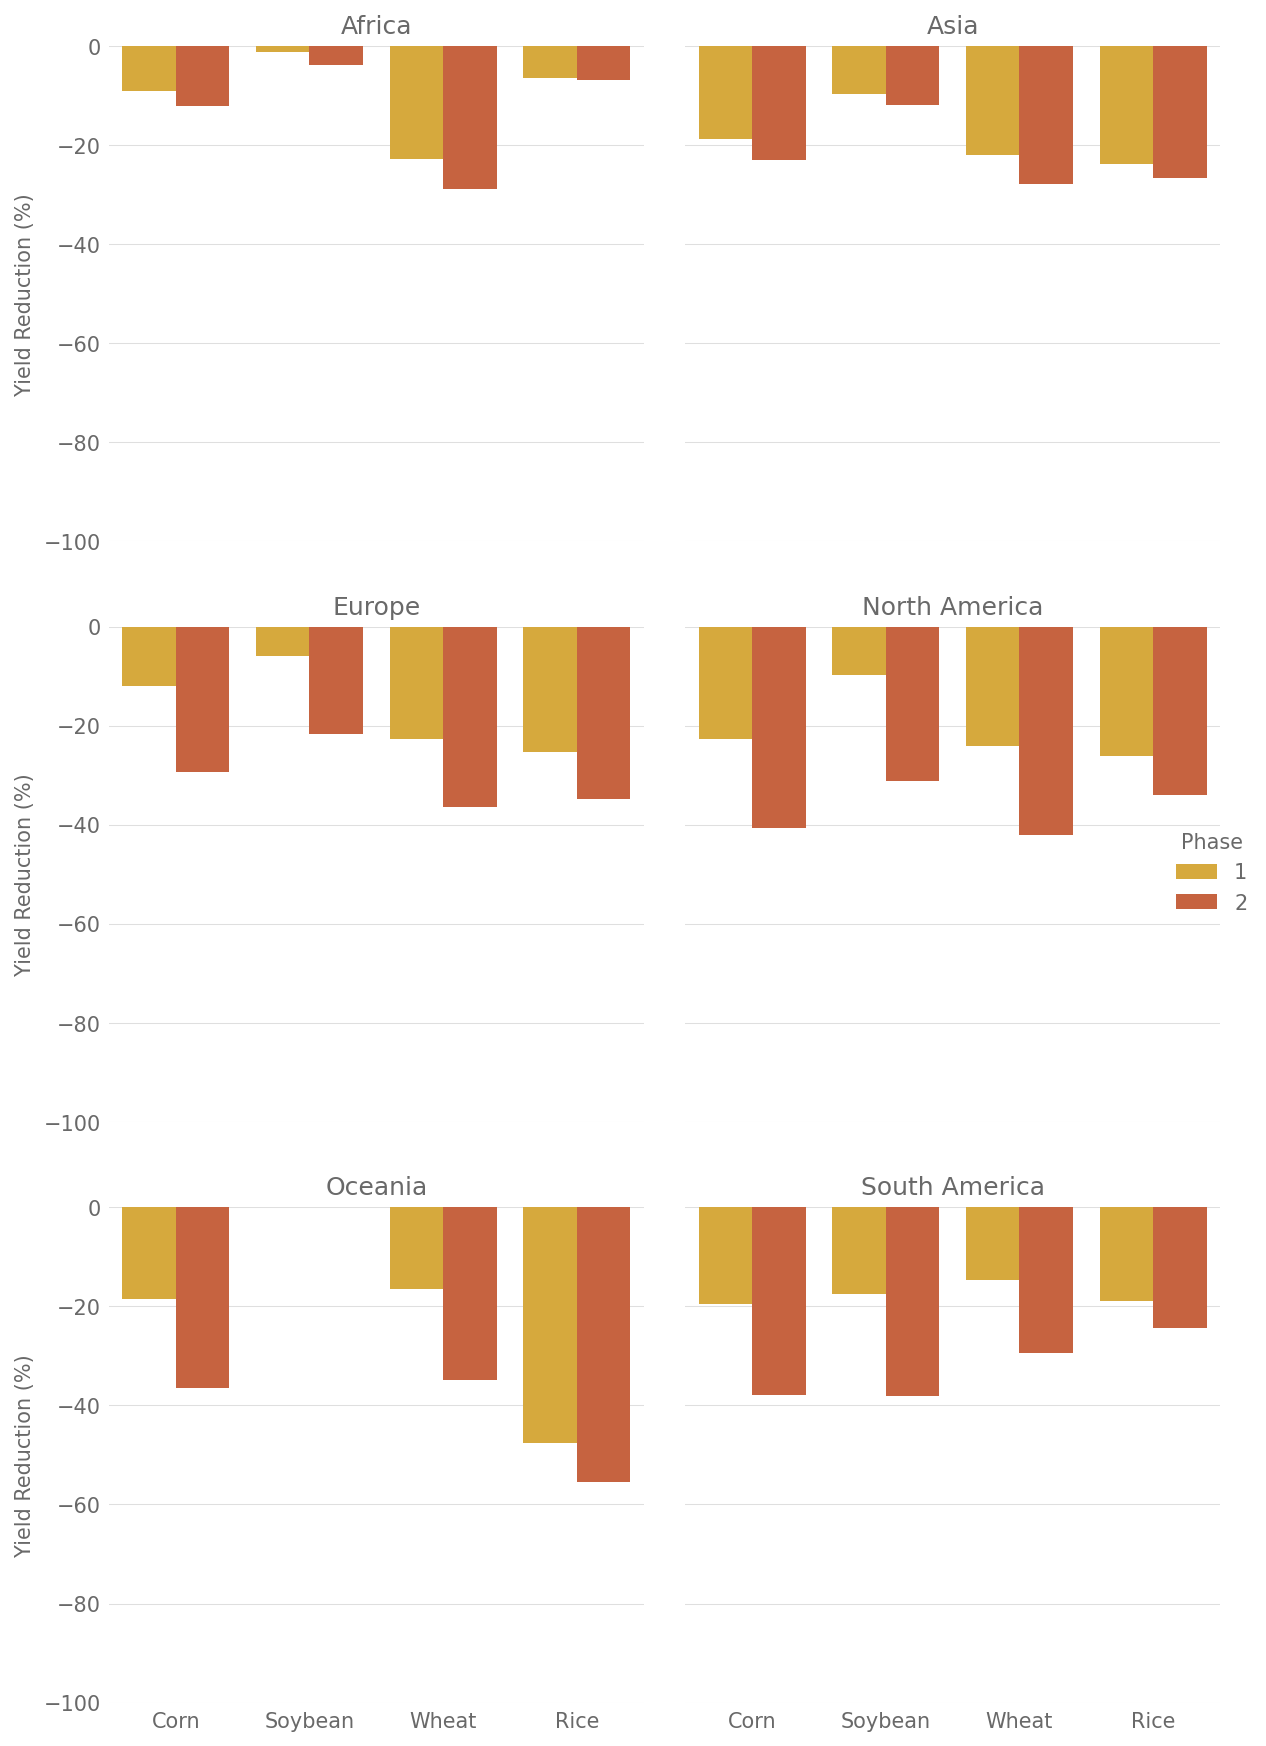

In [24]:


plt.style.use("https://raw.githubusercontent.com/allfed/ALLFED-matplotlib-style-sheet/main/ALLFED.mplstyle")
# Set up the figure and subplots
g = sns.catplot(
        data=region_yield_reduction,
        x='Crop',
        y='Yield Reduction (%)',
        col="Continent",
        hue='Phase',
        kind='bar',
        height=4,
        aspect=1,
        col_wrap=2,
        palette= ['#F0B323', '#DC582A']
    )

# Set the titles for each subplot
for ax in g.axes.flat:
    region = ax.get_title().split(' = ')[1]
    ax.set_title(region)
    ax.set_ylim(-100, 0)
    ax.set_ylabel("Yield Reduction (%)")
    ax.set_xlabel("")
    # Hide borders
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)
    # Set the legend title

# Adjust the spacing between subplots
g.fig.tight_layout(pad=2)

# Show the plot
plt.savefig("../" + os.sep + "reports" + os.sep + "figures" + os.sep + "yield_reduction_by_region.png", dpi=300, bbox_inches='tight')